In [2]:
import pandas as pd
from dataclasses import dataclass
from torch.utils.data import DataLoader
from typing import List
import pytorch_lightning as pl
import torch
from torch import nn
#from losses import gaussian_nll_loss, asymetric_gaussian_nll_loss
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

from utils import TimeseriesDataset
from losses import gaussian_nll_loss

In [3]:
@dataclass
class Configs:
    csv_path : str = "datasets/synthetic_sin_w_asym_noise.csv"
    model_output_path: str = "runs/baseline"
    features = ['sin']
    targets = ['target']
    input_length: int = 10
    learning_rate: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 50
    early_stopping: int = 4
    batch_size: int = 32
    lstm_hidden_size: int = 32
    lstm_num_layers: int = 1
    device: str = "cuda:0"

In [4]:
dataset = pd.read_csv(Configs.csv_path)
dataset = dataset.set_index("date")

In [5]:
train_dataset = TimeseriesDataset(dataset, 
                                  features=Configs.features,
                                  targets=Configs.targets,
                                  input_length=Configs.input_length,
                                  start_date="1980-01",
                                  end_date="1990-01",
                                  scaler=None)

val_dataset = TimeseriesDataset(dataset, 
                                features=Configs.features,
                                targets=Configs.targets,
                                input_length=Configs.input_length,
                                start_date="1990-01",
                                end_date="2000-01",
                                scaler=train_dataset.scaler)

train_loader = DataLoader(train_dataset,
                          batch_size=Configs.batch_size,
                          shuffle=True,
                          num_workers=0)

val_loader = DataLoader(val_dataset,
                        batch_size=Configs.batch_size,
                        shuffle=False,
                        num_workers=0)

In [6]:
class GaussianLSTM(pl.LightningModule):
    def __init__(
        self,
        features: List[str] = ['col'],
        targets: List[str] = ['col'],
        lstm_hidden_size: int = 32,
        lstm_num_layers: int = 1,
        learning_rate: float = 1e-3,
        weight_decay: float = 1e-4,
    ):

        super().__init__()
        self.save_hyperparameters()
        print(f"Init model, hparams:\n{self.hparams}\n")
        self.lstm_encoder = nn.GRU(
            len(features), lstm_hidden_size, lstm_num_layers, batch_first=True
        )
        self.mu = nn.Linear(lstm_hidden_size, len(targets))
        self.sigma = nn.Linear(lstm_hidden_size, len(targets))

    def forward(self, x):
        h, _ = self.lstm_encoder(x)
        h = h[:, -1, :]  # last rnn hidden state
        mu = self.mu(h)
        sigma = self.sigma(h)
        sigma = F.elu(sigma) + 1.0 + 1e-15
        return mu, sigma

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )

    def _step(self, batch, log_mode: str = "train"):
        """ """
        x, y = batch[0], batch[1]
        x = x.to(dtype=torch.float32, device=self.device)
        y = y.to(dtype=torch.float32, device=self.device)
        mu, sigma = self(x)
        loss = gaussian_nll_loss(mu, y, sigma)
        # loss = F.mse_loss(mu, y)
        self.log(f"{log_mode}_loss", loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, log_mode="train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, log_mode="val")

    def predict(self, data_loader: torch.utils.data.DataLoader):
        """Predict function for inference/testing the model

        Args:
            data_loader (torch.utils.data.DataLoader): You should pass the test loader here

        Returns:
            tuple(np.arr, np.arr): predictions, ground_truth
        """
        self.eval()
        result_dfs = []
        for x, y, date in data_loader:
            with torch.no_grad():
                x = x.to(dtype=torch.float32, device=self.device)
                y = y.to(dtype=torch.float32, device=self.device)
                mu, sigma = self(x)
                mu = mu.detach().cpu().numpy()
                sigma = sigma.detach().cpu().numpy()
                y = y.detach().cpu().numpy()
                df_y = pd.DataFrame(index=date, data=y, columns=[f"y_{c}" for c in self.hparams.targets])
                df_mu = pd.DataFrame(index=date, data=mu, columns=[f"mu_{c}" for c in self.hparams.targets])
                df_sigma = pd.DataFrame(index=date, data=sigma, columns=[f"sigma_{c}" for c in self.hparams.targets])
                df_res = pd.concat([df_mu, df_y, df_sigma], axis=1)
                result_dfs.append(df_res)
        return pd.concat(result_dfs)


In [7]:
model = GaussianLSTM(
    features=Configs.features,
    targets=Configs.targets,
    learning_rate=Configs.learning_rate,
    weight_decay=Configs.weight_decay,
    lstm_hidden_size=Configs.lstm_hidden_size,
    lstm_num_layers=Configs.lstm_num_layers
    )
model.to(Configs.device)

Init model, hparams:
"features":         ['sin']
"learning_rate":    0.001
"lstm_hidden_size": 32
"lstm_num_layers":  1
"targets":          ['target']
"weight_decay":     0.0001



GaussianLSTM(
  (lstm_encoder): GRU(1, 32, batch_first=True)
  (mu): Linear(in_features=32, out_features=1, bias=True)
  (sigma): Linear(in_features=32, out_features=1, bias=True)
)

In [8]:
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=Configs.early_stopping,
   verbose=True
)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_weights_only=True)

if Configs.device == "cpu":
    trainer = pl.Trainer(default_root_dir=Configs.model_output_path,
                         max_epochs=Configs.epochs,
                         callbacks=[checkpoint_callback, early_stop_callback])
else:
    device_name, device_id = Configs.device.split(":")  
    assert device_name == "cuda", "Configs>device should be cpu or cuda"  
    trainer = pl.Trainer(default_root_dir=Configs.model_output_path,
                     max_epochs=Configs.epochs,
                     callbacks=[checkpoint_callback, early_stop_callback],
                     gpus=device_id)

trainer.fit(model, 
            train_dataloader=train_loader, 
            val_dataloaders=val_loader)

/home/luisao/miniconda3/envs/simclr/lib/python3.9/site-packages/pytorch_lightning/utilities/device_parser.py:135: LightningDeprecationWarning: Parsing of the Trainer argument gpus='0' (string) will change in the future. In the current version of Lightning, this will select CUDA device with index 0, but from v1.5 it will select gpus [] (same as gpus=0 (int)).
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/luisao/miniconda3/envs/simclr/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:531: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type   | Params
----------------------------------------
0 | lstm_encoder | GRU    | 3.4 K 
1 | mu           | Linear | 33    
2 | sigma  

Validation sanity check: 0it [00:00, ?it/s]

/home/luisao/miniconda3/envs/simclr/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/luisao/miniconda3/envs/simclr/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -1.167


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: -1.235


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: -1.269


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: -1.273


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: -1.279


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: -1.280


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: -1.300


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: -1.304


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: -1.312


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 4 records. Best score: -1.312. Signaling Trainer to stop.


In [9]:
model = GaussianLSTM.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
model.to(Configs.device)

Init model, hparams:
"features":         ['sin']
"learning_rate":    0.001
"lstm_hidden_size": 32
"lstm_num_layers":  1
"targets":          ['target']
"weight_decay":     0.0001



GaussianLSTM(
  (lstm_encoder): GRU(1, 32, batch_first=True)
  (mu): Linear(in_features=32, out_features=1, bias=True)
  (sigma): Linear(in_features=32, out_features=1, bias=True)
)

In [10]:
test_dataset = TimeseriesDataset(dataset, 
                                features=Configs.features,
                                targets=Configs.targets,
                                input_length=Configs.input_length,
                                start_date="2020-01",
                                end_date="2021-02",
                                scaler=train_dataset.scaler)

test_loader = DataLoader(test_dataset,
                        batch_size=Configs.batch_size,
                        shuffle=False,
                        num_workers=0)

In [11]:
df_preds = model.predict(test_loader)
df_preds

,mu_target,y_target,sigma_target
2020-01-11,0.168127,0.281516,0.017978
2020-01-12,0.186047,0.223119,0.018022
2020-01-13,0.204144,-0.001033,0.018080
2020-01-14,0.222488,0.117208,0.018155
2020-01-15,0.241061,0.319280,0.018245
...,...,...,...
2021-01-27,0.500304,0.428215,0.020754
2021-01-28,0.522102,0.362775,0.021057
2021-01-29,0.544059,0.537329,0.021375
2021-01-30,0.566095,0.678984,0.021708


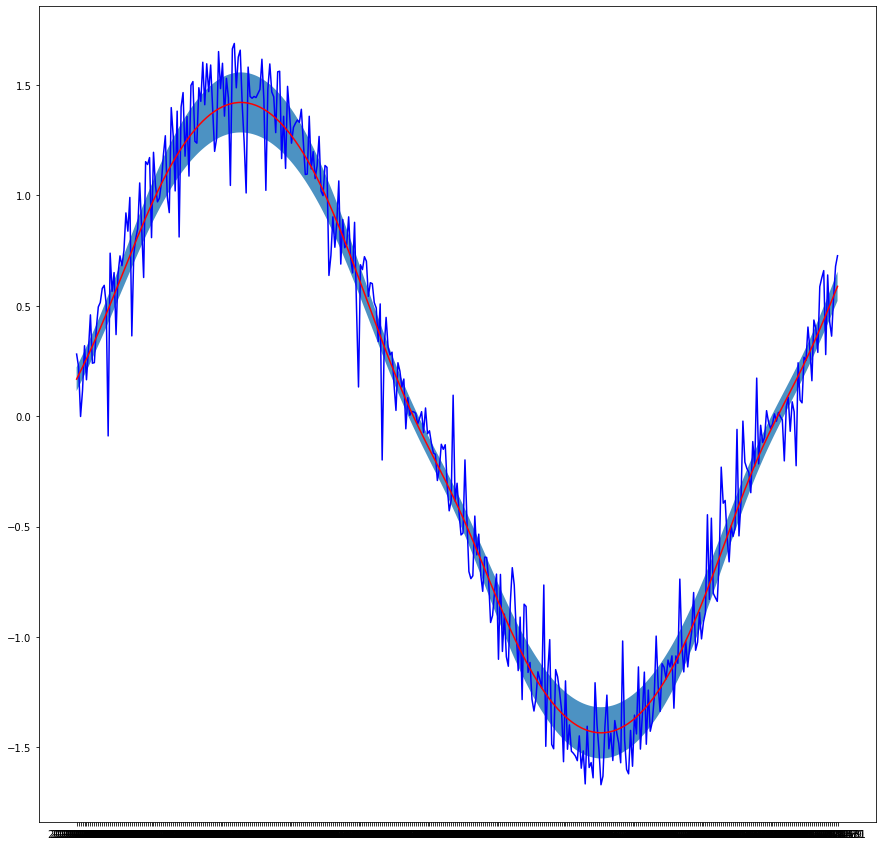

In [13]:
fig, ax = plt.subplots(figsize=(15,15))

y = df_preds["y_target"]
mu = df_preds["mu_target"]
sigma = df_preds["sigma_target"]

ax.plot(df_preds.index, y, '-', color="blue")
ax.plot(df_preds.index, mu, '-', color="red")
ax.fill_between(df_preds.index, 
                mu - 3 * sigma, 
                mu + 3 * sigma, 
                alpha=0.8)
